In [1]:
import pandas as pd
import os

BASE_PATH = r"C:\Users\Pocah\OneDrive\Desktop\bootcamp\ML with python"

# Load climate data
weather = pd.read_csv(
    os.path.join(BASE_PATH, "Dataset-weather-prediction-dataset-processed (1).csv")
)

# Load pleasant weather answers
answers = pd.read_csv(
    os.path.join(BASE_PATH, "Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv")
)

print("✅ Files loaded successfully!")
print("Weather shape:", weather.shape)
print("Answers shape:", answers.shape)


✅ Files loaded successfully!
Weather shape: (22950, 170)
Answers shape: (22950, 16)


#Train split

In [2]:
# Drop DATE and MONTH from weather, DATE from answers (as required)
X = weather.drop(columns=["DATE", "MONTH"])
y = answers.drop(columns=["DATE"])

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (22950, 168)
y shape: (22950, 15)


#Decision Tree Model

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=False,
    random_state=42
)

print("Training data:", X_train.shape, y_train.shape)
print("Testing data:", X_test.shape, y_test.shape)


Training data: (18360, 168) (18360, 15)
Testing data: (4590, 168) (4590, 15)


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

train_acc_dt = accuracy_score(y_train, y_train_pred_dt)
test_acc_dt = accuracy_score(y_test, y_test_pred_dt)

print("Decision Tree Training Accuracy:", round(train_acc_dt, 4))
print("Decision Tree Testing Accuracy:", round(test_acc_dt, 4))


Decision Tree Training Accuracy: 1.0
Decision Tree Testing Accuracy: 0.5763


In [5]:
dt_pruned = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,
    min_samples_leaf=20
)

dt_pruned.fit(X_train, y_train)

train_acc_pruned = accuracy_score(y_train, dt_pruned.predict(X_train))
test_acc_pruned = accuracy_score(y_test, dt_pruned.predict(X_test))

print("Pruned DT Training Accuracy:", round(train_acc_pruned, 4))
print("Pruned DT Testing Accuracy:", round(test_acc_pruned, 4))


Pruned DT Training Accuracy: 0.6438
Pruned DT Testing Accuracy: 0.5582


Confusion Matrices (multi-station)

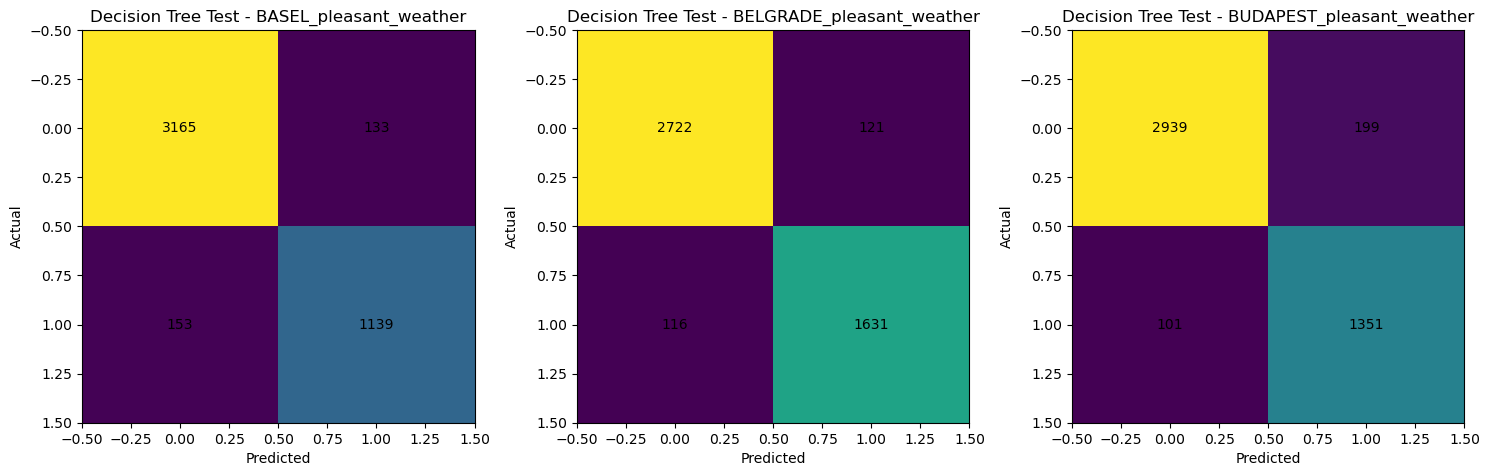

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_multi_station_confusion(y_true, y_pred, station_list, title_prefix):
    n = len(station_list)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5))

    if n == 1:
        axes = [axes]

    for i, st in enumerate(station_list):
        idx = y_true.columns.get_loc(st)
        cm = confusion_matrix(y_true[st], y_pred[:, idx])

        axes[i].imshow(cm)
        axes[i].set_title(f"{title_prefix} - {st}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

        for (row, col), val in np.ndenumerate(cm):
            axes[i].text(col, row, int(val), ha='center', va='center')

    plt.tight_layout()
    plt.show()

# Select 3 tations for visualization
stations = list(y.columns[:3])

plot_multi_station_confusion(y_test, y_test_pred_dt, stations, "Decision Tree Test")


#ANN Model (Scaled)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=300,
    tol=1e-4,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)

y_train_pred_ann = mlp.predict(X_train_scaled)
y_test_pred_ann = mlp.predict(X_test_scaled)

train_acc_ann = accuracy_score(y_train, y_train_pred_ann)
test_acc_ann = accuracy_score(y_test, y_test_pred_ann)

print("ANN Training Accuracy:", round(train_acc_ann, 4))
print("ANN Testing Accuracy:", round(test_acc_ann, 4))


ANN Training Accuracy: 0.8711
ANN Testing Accuracy: 0.5322


C:\Users\Pocah\anaconda3\envs\py310_quandl\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


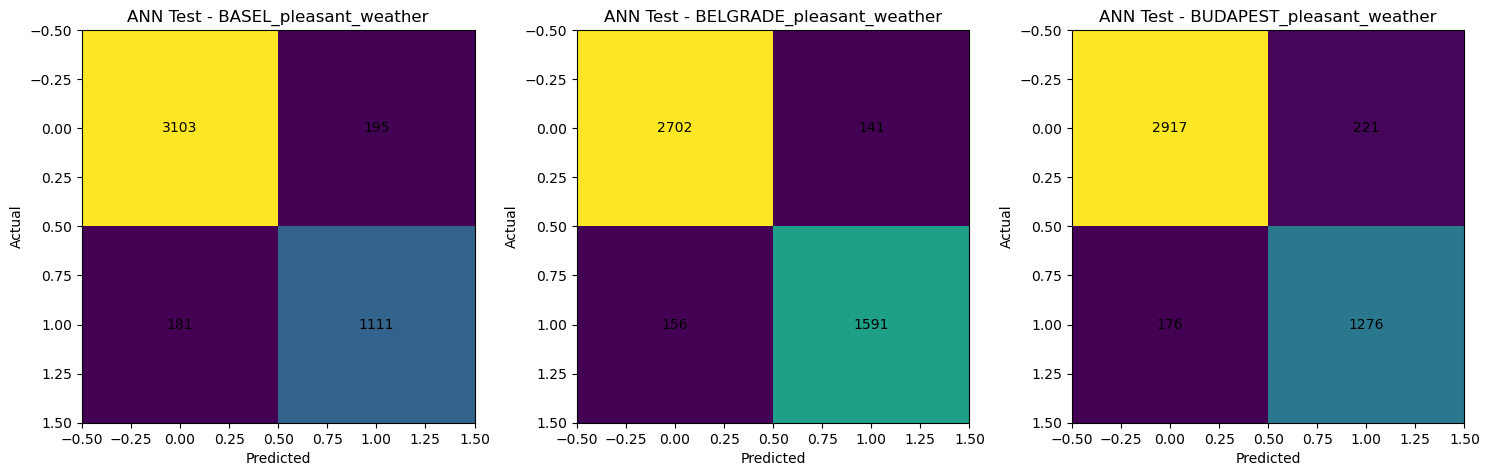

In [8]:
plot_multi_station_confusion(y_test, y_test_pred_ann, stations, "ANN Test")


#unscaled ANN cell

In [9]:
# ANN on UNscaled data for comparison
mlp_unscaled = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=300,
    tol=1e-4,
    random_state=42
)

mlp_unscaled.fit(X_train, y_train)

y_train_pred_ann_unscaled = mlp_unscaled.predict(X_train)
y_test_pred_ann_unscaled = mlp_unscaled.predict(X_test)

train_acc_ann_unscaled = accuracy_score(y_train, y_train_pred_ann_unscaled)
test_acc_ann_unscaled = accuracy_score(y_test, y_test_pred_ann_unscaled)

print("ANN (UNSCALED) Training Accuracy:", round(train_acc_ann_unscaled, 4))
print("ANN (UNSCALED) Testing Accuracy:", round(test_acc_ann_unscaled, 4))


ANN (UNSCALED) Training Accuracy: 0.6635
ANN (UNSCALED) Testing Accuracy: 0.5327


#hyperparameter test loop

In [10]:
configs = [
    ("1x50", (50,), 200, 1e-4),
    ("2x50", (50, 50), 200, 1e-4),
    ("2x100_looser_tol", (100, 100), 300, 1e-3),
]

for name, layers, max_it, tol in configs:
    mlp_cfg = MLPClassifier(
        hidden_layer_sizes=layers,
        max_iter=max_it,
        tol=tol,
        random_state=42
    )
    mlp_cfg.fit(X_train_scaled, y_train)
    train_acc = accuracy_score(y_train, mlp_cfg.predict(X_train_scaled))
    test_acc = accuracy_score(y_test, mlp_cfg.predict(X_test_scaled))
    print(f"{name} | layers={layers}, max_iter={max_it}, tol={tol} "
          f"=> train={train_acc:.4f}, test={test_acc:.4f}")


C:\Users\Pocah\anaconda3\envs\py310_quandl\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1x50 | layers=(50,), max_iter=200, tol=0.0001 => train=0.7064, test=0.5495


C:\Users\Pocah\anaconda3\envs\py310_quandl\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2x50 | layers=(50, 50), max_iter=200, tol=0.0001 => train=0.7279, test=0.5505
2x100_looser_tol | layers=(100, 100), max_iter=300, tol=0.001 => train=0.8910, test=0.5048
